# Piece-wise constant versus piece-wise linear discretization - accuracy for uniform meshes


Plane Elasticity problem 


We explore the rate of convergence of collocation BEM as we refine the mesh for both 2DS0 (piece-wise constant) and 2DS1 (piece-wise linear) elements for the Griffith problem: 2D straight crack in an infinite isotropic elastic medium  under uniform remote tension.

In [1]:
# imports etc.
import sys
import os

from bigwham4py import BEMatrix
import numpy as np
from scipy.sparse.linalg import gmres

sys.path.append(os.path.join(os.getcwd(), '../..'))
from solutions.griffith_crack import width_griffith
import matplotlib.pyplot as plt

We define a function in order to solve the Griffith problem with a given number of elements: either for S0 elements (piece-wise constant displacement interpolation) or S1 elements (piece-wise linear interpolation over the element but discontinuous between element). Note that when computing the relative error norms, or root mean-square error, we excule the last element near the tip.

We also set the elastic properties of the medium. Note that Bigwham's input are the Young's modulus $E$ and Poisson's ratio $\nu$.

In [2]:
G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)

def solveGriffith(nelts,a=1,kernel = "2DS0-H"):
    """Wrapper function to solve the Griffith problem with a given number of elements + element type for a crack in [-a,a] along the e1 axis"""
    coor1D = np.linspace(-a, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)
    # H-matrix parameters - choosen here to have an accurate solution
    max_leaf_size=100
    eta=2.
    eps_aca=1.e-6
    elas_prop = np.array([E, nu])
    h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
    t = np.ones(h.shape[0])
    t[0::2] = 0.
    jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
    d = gmres(h, t,M=jac_ilu,rtol=1e-6)[0]
    dd = d.reshape((-1, 2))
    col_pts = h.getMeshCollocationPoints()
    x_coor_=col_pts[:,0]
    # Crack opening displacement discontinuity from analytical solution 
    # note that 2DS1 segment have their solution at nodes.... 
    # note that 2DS1 segment have displacement disconinuity at element vertex for each element
    if (kernel =="2DS1-H"):
        x_coor_ = np.ones(2*nelts)
        for e in range(nelts):
            x_coor_[e*2:e*2+2]=coor1D[conn[e]]
    w_true=width_griffith(x_coor_,a=1,sig=1,G=1,nu=0.25)
    w_0 = width_griffith(x_coor_*0.,a=1,sig=1,G=1,nu=0.25)
    # we compute error - metric w.o accounting for the point near the tip
    rmse = np.sqrt((np.sum(dd[1:-1,1]-w_true[1:-1])**2)/(w_true.size-2))
    l2rel = (np.linalg.norm((dd[1:-1,1]-w_true[1:-1])))/(np.linalg.norm(w_true[1:-1]))
    l2rel_wo = (np.linalg.norm((dd[1:-1,1]-w_true[1:-1])))/(np.linalg.norm(w_0[1:-1]))
    return x_coor_,dd,w_true,rmse,l2rel,l2rel_wo

## Piece-wise constant interpolation element (2DS0)

Let's first look at the solution for S0 element, using 30 elements. We see that the numerical solution estimate of the fracture width is sligthly larger than the true solution. This is typical for this type of boundary element (see Crouch & Starfield - chapter 5).

NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.00167
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-06, eta = 2
Hierarchical matrix  construction time = :  0.001688
BigWham constructed Hmat of size (30 x 2) X (30 x 2)
--------------------


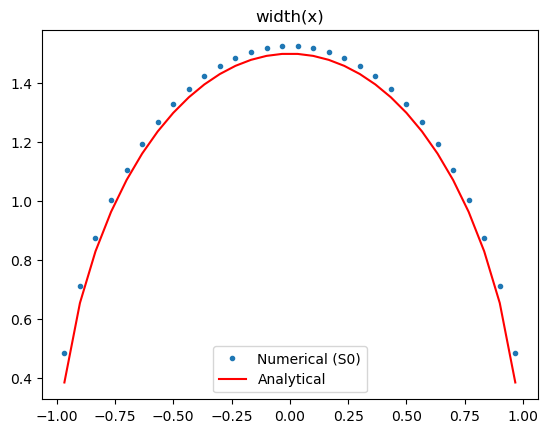

In [ ]:
xcorr,dd_sol,w_true,rmse,l2rel,l2r_w0 = solveGriffith(30,a=1,kernel="2DS0-H")

plt.plot(xcorr, dd_sol[:,1], ".")
plt.plot(xcorr, w_true, "-r") 
plt.title('width(x)')
plt.legend(['Numerical (S0)','Analytical']);

Now, let's perform the same numerical simulation for different number of elements. We solve the problem increase the number of elements from 10 to 10'000. We compute the "approximate" rate of convergence of both the rmse and l2 relative error.
Note that the RMSE and relative L2 norm are defined respetively as

 $$rmse = \sqrt{\sum_{i=1,N} (num_i - true_i)^2/N} $$

 and

 $$L_{2 rel} = \frac{\||  \mathbf{num} - \mathbf{true} \||_2}{\|| \mathbf{true} \||_2}$$

such that the rate of convergence of the rmse is about 1/2 of the one of the relative L2 norm.

To esitmate the rate of convernce of an error metric $e$, we compute:
$$ \beta = \log{(e_2/e_1)}/\log{(N_1/N_2)} $$

where $e_1$ is the error for $N_1$ unknowns, respectively for $e_2$ (with $N_2<N_1$). 

In [23]:
list_nelts_P0=np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse_P0 =[]
l2_rel_P0 = []
l2_rel_wo_P0 = []
for n in list_nelts_P0:
    col_pts,dd_sol,wtr,rmse_n,lerel_n,lerel_wo_n = solveGriffith(n,a=1,kernel="2DS0-H")
    rmse_P0.append(rmse_n)
    l2_rel_P0.append(lerel_n)
    l2_rel_wo_P0.append(lerel_wo_n)
    
# computing the rate of convergence
beta_rmse_P0 = [1 * np.log(rmse_P0[i]/rmse_P0[i-1])/np.log(list_nelts_P0[i-1]/list_nelts_P0[i]) for i in range(2,list_nelts_P0.size-1)]
beta_l2_P0 = [1 * np.log(l2_rel_P0[i]/l2_rel_P0[i-1])/np.log(list_nelts_P0[i-1]/list_nelts_P0[i]) for i in range(2,list_nelts_P0.size-1)];

NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000443
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-06, eta = 2
Hierarchical matrix  construction time = :  0.000462
BigWham constructed Hmat of size (10 x 2) X (10 x 2)
--------------------
NUM OF AVAILABL

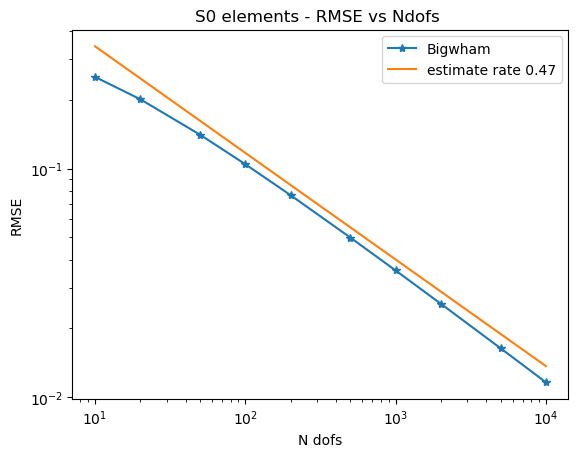

In [39]:
plt.loglog(list_nelts_P0, rmse_P0, "-*")
plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_rmse_P0), "-")
plt.title('S0 elements - RMSE vs Ndofs ')
plt.xlabel('N dofs')
plt.ylabel('RMSE')
plt.legend(['Bigwham','estimate rate '+str(np.median(beta_rmse_P0[::]).round(decimals=2))]);

0.9137943268470415


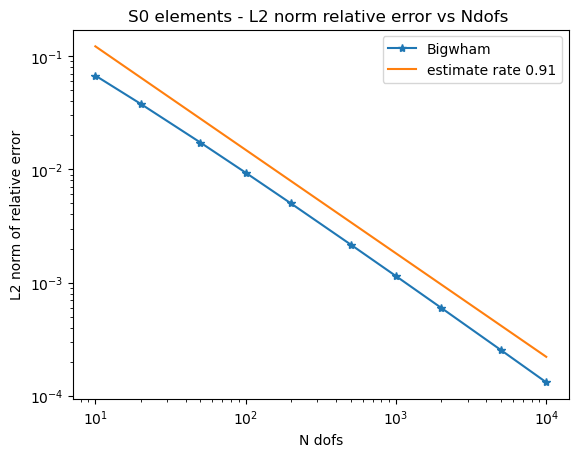

In [34]:
plt.loglog(list_nelts_P0, l2_rel_P0, "-*")
plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_l2_P0), "-")
plt.title('S0 elements - L2 norm relative error vs Ndofs ')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative error')
plt.legend(['Bigwham','estimate rate '+str(np.median(beta_l2_P0[::]).round(decimals=2))]);


## Piece-wise linear element (2DS1)

We now move to the case of piece-wise linear elements. First, we perform a simulation with N=10 elements such that we can 'compare' with the solution obtained with 20 S0 elements. Because it's fast we recompute here the S0 solution too. The solution with S1 elements is much more accurate than the S0 element for the same number of degree of freedoms, except near the tip (where the numerical opening obtained with S1 element is not zero)... the linear discretization is still insufficient to capture the LEFM square-root near-tip behavior.

```{important}
The unknown of the piece-wise linear element are located at the vertex of the element, while the collocation points (where equilibrium is enforced) are located within the element at $[-a/\sqrt{2},a/\sqrt{2} ]$ (for an element of size $h=2a$).
```


NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000946
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-06, eta = 2
Hierarchical matrix  construction time = :  0.000964
BigWham constructed Hmat of size (20 x 2) X (20 x 2)
--------------------
NUM OF AVAILABL

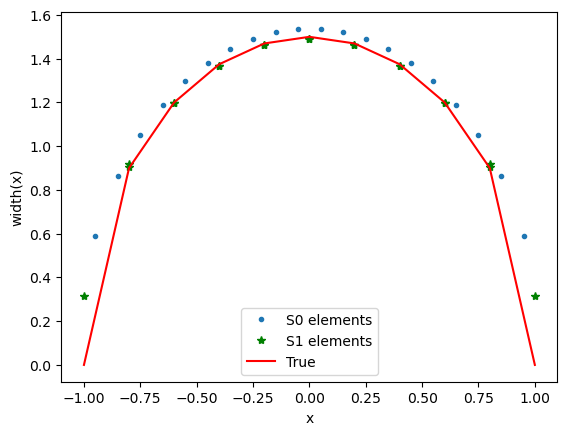

In [38]:
x_corr_P0,dd_sol_P0,w_true_P0,rmse_P0_e,l2rel_P0_e,l2rel_P0_e_wo = solveGriffith(20,a=1,kernel="2DS0-H")
x_corr_P1,dd_sol_P1,w_true_P1,rmse_P1_e,l2rel_P1_e,l2rel_P1_e_wo  = solveGriffith(10,a=1,kernel="2DS1-H")

plt.plot(x_corr_P0, dd_sol_P0[:,1], ".")
plt.plot(x_corr_P1, dd_sol_P1[:,1], "*g")
plt.plot(x_corr_P1, w_true_P1, "-r") 
plt.ylabel('width(x)')
plt.xlabel('x')
plt.legend(['S0 elements','S1 elements','True'])

print('RMSE - SO elements:',rmse_P0_e,', Relative error (L2) - S0 elements: ',l2rel_P0_e)
print('RMSE - S1 elements:',rmse_P1_e,', Relative error (L2) - S1 elements: ',l2rel_P1_e)


We now turn to explore the convergence rate for piece-wise linear S1 elements. Keep in mind that here the number of dof is twice the number of elements ! we therefore perform simulations with a discretization half of the ones previusly used for S0 elements.

In [15]:
list_nelts_P1_aux=(list_nelts_P0/2)

list_nelts_P1=list_nelts_P1_aux.astype(int)
#np.array([10,20,50,100,200,500,1000,2000,5000,10000])
rmse_P1 =[]
l2_rel_P1 = []
for n in list_nelts_P1:
    col_pts,dd_sol,wtr,rmse_n,lerel_n,leresl_wo_n = solveGriffith(n,a=1,kernel="2DS1-H")
    rmse_P1.append(rmse_n)
    l2_rel_P1.append(lerel_n)
    
# computing the rate of convergence
beta_rmse_P1 = [1 * np.log(rmse_P1[i]/rmse_P1[i-1])/np.log(list_nelts_P1[i-1]/list_nelts_P1[i]) for i in range(2,list_nelts_P1.size-1)]
beta_l2_P1 = [1 * np.log(l2_rel_P1[i]/l2_rel_P1[i-1])/np.log(list_nelts_P1[i-1]/list_nelts_P1[i]) for i in range(2,list_nelts_P1.size-1)]

NUM OF AVAILABLE OMP THREADS: 16
BigWham using 8 OpenMP threads
 Now setting things for kernel ... 2DS1-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  1e-06
 binary cluster tree depth =0
 Number of blocks =1
 Number of full blocks =1
 Number of low rank blocks =0
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.000357
Compression ratio - 1
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 1, eps_aca = 1e-06, eta = 2
Hierarchical matrix  construction time = :  0.000375
BigWham constructed Hmat of size (10 x 2) X (10 x 2)
--------------------
NUM OF AVAILABL

The convergence on the RMSE is smaller than for S0 -  exhibiting an  drop early on (so we exclude the first few points for the estimate of the convergence rate). Note however, than the values are lower than the S0 for the same number of dofs.

0.32847190738597953


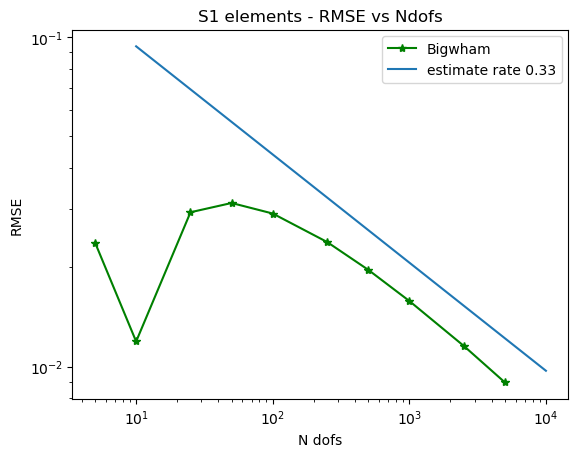

In [ ]:
plt.loglog(list_nelts_P1,rmse_P1, "-*g")
plt.loglog(2*list_nelts_P1, 0.2/(2*list_nelts_P1)**np.median(beta_rmse_P1[5::]), "-")
plt.title('S1 elements - RMSE vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('RMSE')
plt.legend(['Bigwham','estimate rate '+str(np.median(beta_rmse_P1[5::]).round(decimals=2))]);

The convergence of the L2 norm is "cleaner" and exhibit the same rate than for P0 element. However, again, the error is consistently smaller for the same number of dofs.

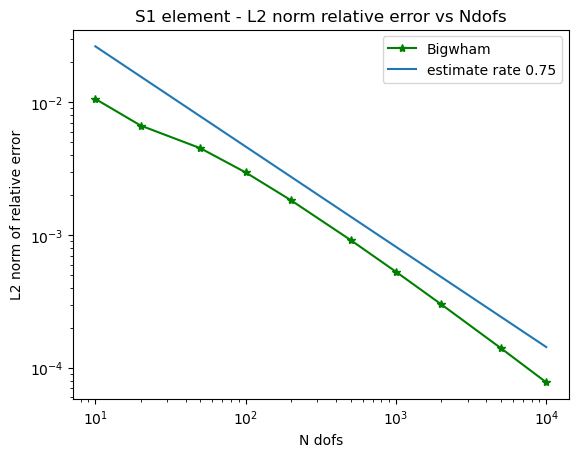

In [ ]:
plt.loglog(list_nelts_P0, l2_rel_P1, "-*g")
plt.loglog(list_nelts_P0, .15/list_nelts_P0**np.median(beta_l2_P1), "-")
plt.title('S1 element - L2 norm relative error vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative error')
plt.legend(['Bigwham','estimate rate '+str(np.median(beta_l2_P1[::]).round(decimals=2))]);

We now compare on the same plot the convergence of the P0 and P1 elements... of course as function of the number of degree of freedoms (number of unknowns).

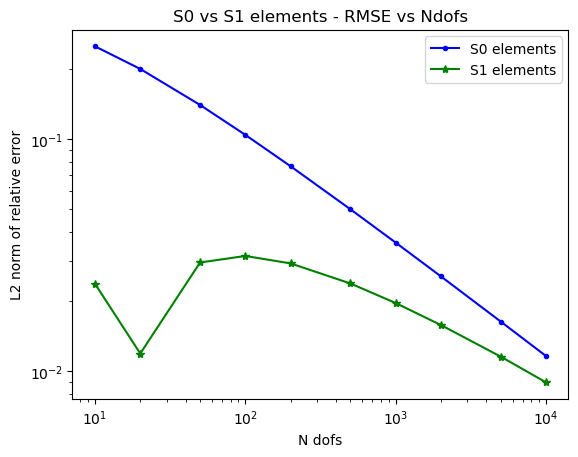

In [27]:
plt.loglog(list_nelts_P0,rmse_P0, ".-b")
plt.loglog(list_nelts_P0,rmse_P1, "*-g")
#
plt.title('S0 vs S1 elements - RMSE vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative error')
plt.legend(['S0 elements','S1 elements']);

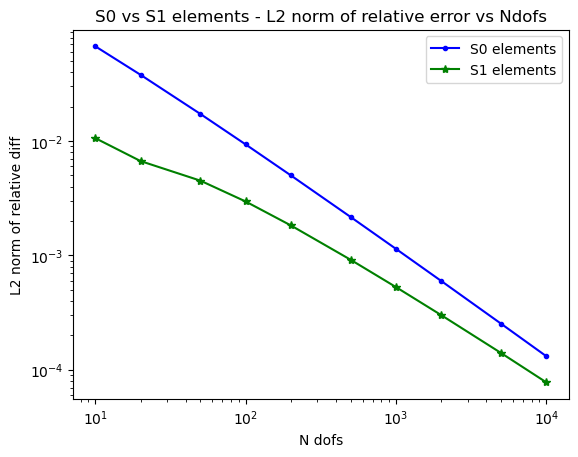

In [ ]:
plt.loglog(list_nelts_P0, l2_rel_P0, ".-b")
plt.loglog(list_nelts_P0, l2_rel_P1, "-*g")
#
#plt.loglog(list_nelts_P0, 1/list_nelts_P0**np.median(beta_l2_P1), "-")
plt.title('S0 vs S1 elements - L2 norm of relative error vs Ndofs')
plt.xlabel('N dofs')
plt.ylabel('L2 norm of relative diff')
plt.legend(['S0 elements','S1 elements']);